# Lecture 1. Introduction to CUDA Programming Model and Toolkit.



Welcome to the GPU short course exercies!

During this course we will introduce you with the syntax of CUDA programming in Python using `numba.cuda` package.

During the first lecture we will try to focus on optimizing the following function, which adds two vectors together using a single CPU core.

In [1]:
import numpy as np

def add_vectors(a, b):
    assert len(a) == len(b)
  
    n = len(a)
    result = [None]*n
    for i in range(n):
        result[i] = a[i] + b[i]
    return result

add_vectors([1, 2, 3, 4], 
            [4, 5, 6, 7])

[5, 7, 9, 11]

Lets measure the time needed to execute the `add_vectors` for big-scale arrays:

In [2]:
a = np.random.rand(2**24) # ~ 1e7 elements
b = np.random.rand(2**24)

In [3]:
%%timeit -n 2
add_vectors(a, b)

2 loops, best of 5: 6.46 s per loop


In the following sections we will show you how to optimize the above implementation by reimplementing vector addition on GPU.

## Exercise 1.1. CUDA kernels and CUDA threads.



#### 1.1.1. One-dimensional grid.

Lets do the all necessary Python imports first.

In [4]:
import math
from numba import cuda
import numpy as np

The `numba.cuda` package provides a possibility to write CUDA kernels directly in Python language.  We will describe Numba in more detail later. For now, it will be enough to understand that:
- the code that is executed by each GPU core separately is called a *GPU kernel*,
- in Numba, GPU kernel is a Python function with `@cuda.jit` decorator.

The below code creates a CUDA kernel which simply does nothing (*NOP*).

In [ ]:
@cuda.jit
def my_first_gpu_kernel():
    pass

The following line launches the code to be executed by 64 thread blocks, each block has 256 threads:

In [ ]:
my_first_gpu_kernel[64, 256]()

Ok, now that we know what is the syntax for writing and lanuching CUDA kernel code, we can proceed with porting the `add_vectors` function to the GPU device. 

The key is to note that vector element additions are *independent tasks* - that is, for each `i` and `j`, the result of `a[i]+b[i]` does not depend on `a[j]+b[j]` and vice versa.

So, let's move line 9 from `add_vectors` function to the new, GPU kernel implementation: 

In [ ]:
@cuda.jit
def add_vectors_kernel(result, a, b):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x

    # Make sure not to go outside the grid area!
    if i >= len(result):
        return

    result[i] = a[i] + b[i]

The above code is executed by each CUDA thread separately. 

Fields `blockIdx`, `blockDim` and `threadIdx` allows to determine the position of the current thread in the whole grid of threads executed by CUDA device:
- `blockIdx` is the identifier of the currently executed block of threads in the grid,
- `blockDim` is the size of a single block of threads,
- `threadIdx` is the identifier of the currenty executed thread within a single block.

A grid of threads can have one, two or three dimensions, described by `(cuda.blockIdx.z, cuda.blockDim.y, cuda.blockDim.x)` tuple. 

Each thread in a block has coordinates `(cuda.threadIdx.z, cuda.threadIdx.y, cuda.threadIdx.x)`. 

Each block in a grid has coordinates `(cuda.blockIdx.z, cuda.blockIdx.y, cuda.blockIdx.x)`. 

The `x` coordinate changes the fastest: two adjacent threads in the same block differ in the value of the `x` coordinate by 1.

Grird and thread dimensions can be specified via `grid_size` and `thread_size` parameters: a single scalar value means, that a 1-D grid will be used, a pair of values imposes a 2-D grid, three values sets 3-D grid. 

Now, we would like to run the above kernel for each `result[i]`. Let's assume for a moment that we want the above CUDA kernel to be executed by 256 threads in parallel - i.e. one block will consists of 256 threads. To cover the entire input array, the kernel has to be executed by $\left\lceil \frac{n}{256} \right\rceil$ blocks of threads.  

In [ ]:
def add_vectors_gpu(a, b):
    assert len(a) == len(b)
    # Create output array in the GPU memory.
    result = cuda.device_array(shape=a.shape, dtype=a.dtype)

    block_size = 256
    grid_size = math.ceil(len(a)/block_size)
    add_vectors_kernel[grid_size, block_size](result, a, b)
    return result.copy_to_host()

In [ ]:
%%timeit
add_vectors_gpu(a, b)

1 loop, best of 5: 138 ms per loop


Congratulations! Your very first GPU kernel, i.e. `add_vectors_gpu` function, executes much faster than its CPU counterpart.
Of course, writing CUDA kernels is not the only part of preparing GPU processing pipeline. One of the other important things to consider is the heterogenous nature of the CPU-GPU processing: is the data transfer between GPU and the host computer.

#### 1.1.2. Two-dimensional grid.

In the previous example, the grid of threads was defined in a single dimension, i.e. the variables `grid_size` and `block_size` were a single scalar value. This time we will implement a function, which adds two **matrices**, and we will use a 2-D grid of threads for this purpose.

Lets implement `add_matrices` for CPU first. 

In [ ]:
import itertools
import numpy as np 

def add_matrices(a, b):
    a = np.array(a)
    b = np.array(b)
    assert a.shape == b.shape
    
    height, width = a.shape
    result = np.zeros(a.shape, dtype=a.dtype)
    
    for i, j in itertools.product(range(height), range(width)):
        result[i, j] = a[i, j] + b[i, j]
    return result

add_matrices(
    # a = 
    [[ 1,  2,  3,  4], 
     [ 4,  5,  6,  7]],
    # b =  
    [[-1, -2, -3, -4],
     [ 1,  1,  1,  1]])

array([[0, 0, 0, 0],
       [5, 6, 7, 8]])

In [ ]:
A = np.random.rand(2**12, 2**12) # ~ 1e7 elements
B = np.random.rand(2**12, 2**12)

C = add_matrices(A, B)
np.testing.assert_equal(C, A+B)

In [ ]:
%%timeit -n 2
add_matrices(A, B)

2 loops, best of 5: 8.95 s per loop


Similarly to the `add_vectors_kernel` implementation,  the `add_matrices_kernel` will compute a single matrix element. This time, we will use `y` coordinate to address matrix elements in the second dimension:



In [ ]:
@cuda.jit
def add_matrices_kernel(result, a, b):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    j = cuda.blockIdx.y*cuda.blockDim.y + cuda.threadIdx.y

    height, width = result.shape

    # Make sure we are not accessing data outside available space!
    if i >= width or j >= height:
        return

    result[j, i] = a[j, i] + b[j, i]

Now, we must also pass the second dimension of the grid to the GPU kernel invocation parameters, as the implementation assumes a 2-D grid layout. The parameters `grid_size` and `block_size` now has to pairs of integer values:  

In [ ]:
def add_matrices_gpu(a, b):
    assert a.shape == b.shape
    # Create output array in the GPU memory.
    result = cuda.device_array(shape=a.shape, dtype=a.dtype)

    height, width = a.shape
    block_size = (16, 16)
    grid_size = (math.ceil(width/block_size[0]), math.ceil(height/block_size[1]))
    add_matrices_kernel[grid_size, block_size](result, a, b)
    return result.copy_to_host()

add_matrices(
    # a = 
    [[ 1,  2,  3,  4], 
     [ 4,  5,  6,  7]],
    # b =  
    [[-1, -2, -3, -4],
     [ 1,  1,  1,  1]])

array([[0, 0, 0, 0],
       [5, 6, 7, 8]])

Let's test the implementation first:

In [ ]:
C = add_matrices_gpu(A, B)
np.testing.assert_equal(C, A+B)

Now lets compare CPU and GPU processing time:

In [ ]:
%%timeit
add_matrices_gpu(A, B)

10 loops, best of 5: 140 ms per loop


We leave the implementation of adding two 3D arrays as homework for the students.

#### 1.1.3. See also

- CUDA kernels in Numba: introduction: https://numba.readthedocs.io/en/0.52.0/cuda/kernels.html#introduction

- Matrix multiplication example https://numba.readthedocs.io/en/0.52.0/cuda/examples.html#matrix-multiplication

## Exercise 1.2. Transferring data to and from GPU memory.



In the previous examples, we passed the `numpy` arrays directly to the GPU kernel code. The `numpy` arrays were stored in the host PC's operating memory. As GPU computing can be performed only on data which is located in GPU memory, Numba package impliclitly transferred the data from PC's memory to GPU global memory first.

The data transfers can be run explicitly, if necessary:

In [ ]:
block_size = 256
grid_size = math.ceil(len(a)/block_size)

# Create an array for the result in the GPU global memory.  
result_gpu = cuda.device_array(shape=a.shape, dtype=a.dtype)
# Here are the explicit data transfers from host PC memory to GPU global memory:
a_gpu = cuda.to_device(a)
b_gpu = cuda.to_device(b)

add_vectors_kernel[grid_size, block_size](result_gpu, a_gpu, b_gpu)
# After the computations are done, transfer the results to the host PC memory.
result = result_gpu.copy_to_host()

Data transfer to and from GPU memory is only possible with GPU global memory. The following functions are available in Numba:

- create an array in the GPU global memory: `numba.cuda.device_array`, or `numba.cuda.device_array_like`,
- host PC to GPU global memory transfer: `numba.cuda.to_device`
- GPU global memory to host PC memory transfer: `gpu_array.copy_to_host`, where `gpu_array` is a GPU array. 

The complete list of Numba's functions for data transfer to and from GPU is available here:
https://numba.readthedocs.io/en/0.52.0/cuda/memory.html#data-transfer

The advantage of heterogenous programming with CUDA is that computing performed on the GPU can be done in parallel with the operations performed by CPU -- both CPU and GPU are separate processing devices that can work simultaneously. In other words, that CUDA kernel invocations are **asynochronous**: when we invoke GPU kernel, the only job the CPU does is to enqueue the kernel to be executed on GPU, then it returns immediately
(In fact, this is not always true for kernels written in Numba - the first launch of a CUDA kernel may also require Python code compilation. This topic will be discussed later in this lecture.)

For example, the following GPU kernel call takes much less time than we've seen so far:

In [ ]:
%%timeit -n 100
add_vectors_kernel[grid_size, block_size](result_gpu, a_gpu, b_gpu)

100 loops, best of 5: 172 µs per loop


The difference is that we did not transfer data from the GPU to the CPU. Let's try now with the GPU -> CPU transfer:

In [ ]:
%%timeit -n 100
add_vectors_kernel[grid_size, block_size](result_gpu, a_gpu, b_gpu)
result = result_gpu.copy_to_host()

100 loops, best of 5: 34.6 ms per loop


The difference is due to the fact that the data transfer is a blocking operation - it waits for all queued operations to be performed, then performs the transfer. To wait for the kernels to execute explicitly, without transferring the result data to host PC, run `cuda.default_stream().synchronize()`.

In [ ]:
%%timeit -n 100
add_vectors_kernel[grid_size, block_size](result_gpu, a_gpu, b_gpu)
cuda.default_stream().synchronize()

100 loops, best of 5: 1.8 ms per loop


CUDA streams will be covered in more detail later in this short-course.

### 1.2.1 See also

- CUDA Toolkit documentation: device memory management (CUDA C++): https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#device-memory
- The complete list of Numba's functions for data transfer to and from GPU: https://numba.readthedocs.io/en/0.52.0/cuda/memory.html#data-transfer


## Exercise 1.3. CUDA Toolkit and Numba package.

Nvidia provides several tools in its Toolkit that help in the implementation and testing of the GPU code. In this exercise we will show you how to:
- check what parameters you hardware has, like determine how to programatically check how many GPUs are available, how much each kind of memory you it has, and so on,
- debug and memcheck you Python CUDA kernels,
- profile CUDA code execution time.

Also, we will introduce you with more details of Numba Python package, which we will use during the whole course.

### Exercise 1.3.1. CUDA device diagnostics.

The most basic diagnostic tool for GPU cards is `nvidia-smi` which displays the current status of available all GPU cards.

(NOTE: `nvidia-smi` tool is not available Nvidia Jetson processors. For SoC chips, please use built-in `tegrastats` or install [`jtop`](https://pypi.org/project/jetson-stats/)).

In [ ]:
! nvidia-smi

Sun Jun 27 10:32:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    66W /  70W |   1256MiB / 15109MiB |     86%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

`nvidia-smi` outputs information about:
- the installed NVIDIA driver and CUDA Toolkit,
- for each available GPU:
  - temperature, memory usage and GPU utilization,
  - processes that are currently running on that GPU.

 

`nvidia-smi` is a command line tool, so use it in your shell to quickly check the state of your GPU. 

CUDA SDK provides also a programatic way to access device description in your application run-time, to e.g. check if we are not exceeding available GPU global memory.

The CUDA device description is called SDK *device properties*. 

To get the device properties, we will use `cupy` package, which exposes CUDA SDK interface in Python in a convenient way.

Let's check first how many GPU cards do we have:



In [ ]:
import cupy as cp
cp.cuda.runtime.getDeviceCount()

1

Now, let's we check:

- what is the name of the device and what is its compute capability,
- what is the GPU clock frequency,
- how much global, shared and constant memory our GPU card has.

In [ ]:
device_props = cp.cuda.runtime.getDeviceProperties(0)

print(f"Device: {device_props['name']} (cc {device_props['major']}.{device_props['minor']})")
print(f"GPU clock frequency: {device_props['clockRate']/1e3} MHz")
print("Available memory: ")
print(f"- global memory: {device_props['totalGlobalMem']/2**20} MiB")
print(f"- shared memory per thread block: {device_props['sharedMemPerBlock']} B")
print(f"- constant memory: {device_props['totalConstMem']} B")

Device: b'Tesla T4' (cc 7.5)
GPU clock frequency: 1590.0 MHz
Available memory: 
- global memory: 15109.75 MiB
- shared memory per thread block: 49152 B
- constant memory: 65536 B


The complete list of device properties is available [here](https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__DEVICE.html#group__CUDART__DEVICE_1g1bf9d625a931d657e08db2b4391170f0).


### Exercise 1.3.2. Numba.

- Numba is a just-in-time (JIT) compiler for Python.
- It generates machine code from Python bytecode using LLVM compiler library, which results in a significant speed up.
- It works best on code that uses NumPy arrays and functions, and loops.
- Numba can target NVIDIA CUDA and (experimentally) AMD ROC GPUs. In other words, it allows for (relatively) easy creation of Python code executed on GPU, which results (potentially) in a significant speed-up.

Numba documentation is available here: https://numba.pydata.org/numba-doc/latest/index.html

The thing that needs to be stressed here is to note, that Numba is a JIT compiler - that means it compiles a given function to machine code *lazily*, **on the first function call**. Compilation is performed only once - the first time a given function is run. After that, a cached version of machine code is used.

Let's see how long it will take to execute the brand new kernel the first time:

In [ ]:
@cuda.jit
def increment(x):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    x[i] += 2

In [ ]:
%time increment[1, 5](np.arange(5))

CPU times: user 125 ms, sys: 5.01 ms, total: 130 ms
Wall time: 132 ms


The second kernel execution takes:

In [ ]:
%time increment[1, 5](np.arange(5))

CPU times: user 1.52 ms, sys: 10 µs, total: 1.53 ms
Wall time: 1.34 ms


### Exercise 1.3.3. CUDA-MEMCHECK and debugging Numba code.


#### 1.3.3.1 CUDA-MEMCHECK

CUDA-MEMCHECK is an tool available in CUDA SDK, which gives the possibility to check if CUDA application makes any of the following errors:
- misaligned and out of bounds memory access errors,
- shared memory data races,
- unintialized accesses to global memory. 

Let's to debug below Python script in order to detect any memory issues it may cause. According to Numba [documentation](https://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#debug-info), we can pass `debug=True` parameter to the `@cuda.jit` decorator in order to get some more information about the analyzed kernel. Let's do that, save the below cell to Python script, and run CUDA-MEMCHECK for the Python interpreter.

In [ ]:
%%writefile 1_3_3_memcheck.py

import os 
import numpy as np
from numba import cuda
import math

@cuda.jit(debug=True)
def add_vectors_invalid(result, a, b):
    pass
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    # What are we missing here?
    result[i] = a[i] + b[i]


a = np.arange(255)
b = np.arange(255)
result = cuda.device_array(a.shape, dtype=a.dtype)

add_vectors_invalid[1, 256](result, a, b)
result_host = result.copy_to_host()

Writing 1_3_3_memcheck.py


The only thing the above cell does is saving the Python code to the `1_3_3_memcheck.py` script in the current directory (you can check it using `! pwd` command). Now, we can run `cuda-memcheck` along with the Python interpreter in order to see if there any issues with the script.

In [ ]:
! cuda-memcheck --show-backtrace no python 1_3_3_memcheck.py

========= CUDA-MEMCHECK
========= Invalid __global__ read of size 8
=========     at 0x00000490 in cudapy::__main__::add_vectors_invalid$241(Array<__int64, int=1, C, mutable, aligned>, Array<__int64, int=1, C, mutable, aligned>, Array<__int64, int=1, C, mutable, aligned>)
=========     by thread (255,0,0) in block (0,0,0)
=========     Address 0x7fb806200ff8 is out of bounds
========= Program hit CUDA_ERROR_LAUNCH_FAILED (error 719) due to "unspecified launch failure" on CUDA API call to cuMemcpyDtoH_v2.
Traceback (most recent call last):
  File "1_3_3_memcheck.py", line 19, in <module>
    add_vectors_invalid[1, 256](result, a, b)
  File "/usr/local/lib/python3.7/dist-packages/numba/cuda/compiler.py", line 770, in __call__
    self.stream, self.sharedmem)
  File "/usr/local/lib/python3.7/dist-packages/numba/cuda/compiler.py", line 862, in call
    kernel.launch(args, griddim, blockdim, stream, sharedmem)
  File "/usr/local/lib/python3.7/dist-packages/numba/cuda/compiler.py", line 655,

As we can see, CUDA-MEMCHECK detected, the `add_vectors_invalid` kernel was not properly executed by thread `255`. What is causing the issue?

#### 1.3.3.2 Debugging Numba kernels

CUDA SDK toolkit includes debuggers that can be run on the GPU kernel code, in case it's necessary to trace the cause of the issue. A list of CUDA debuggers, that can be run on C++ CUDA kernel code is available here: [Linux](https://docs.nvidia.com/cuda/cuda-gdb/index.html), [Windows](https://docs.nvidia.com/nsight-visual-studio-edition/cuda-debugger/).

For the application that uses Python with Numba to generate GPU machine code, user have an opportunity to run Python debugger (`pdb`) directly on the kernel code using the CUDA simulator. More details about the simulator can be found [here](https://numba.pydata.org/numba-doc/dev/cuda/simulator.html). 

Let's use CUDA simulator to print debug data directly in the kernel code. In order to be able to run CUDA simulator, set `NUMBA_ENABLE_CUDASIM` environment variable to value `1`. 

In [ ]:
%%writefile 1_3_3_numba_debugger.py

# Turn on CUDA simulator.
import os 
os.environ['NUMBA_ENABLE_CUDASIM'] = '1'

import numpy as np
from numba import cuda
import math

@cuda.jit
def add_vectors(result, a, b):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    # What are we missing here?
    result[i] = a[i] + b[i]
    if i == 10:
        print(f"{result[i]} = {a[i]} + {b[i]}")
        # or use PDB: import pdb; pdb.set_trace()

a = np.arange(255)
b = np.arange(255)
result = cuda.device_array(a.shape, dtype=a.dtype)

add_vectors[1, 255](result, a, b)
result_host = result.copy_to_host()

Writing 1_3_3_numba_debugger.py


In [ ]:
! python 1_3_3_numba_debugger.py

20 = 10 + 10


### Exercise 1.3.4. Profiling GPU code.


Sometimes, to better understand and optimize performance of GPU appplication, it is necessary to perform a dynamic program analysis and to mesaure a specific metrics, for example the execution time and memory requirements of a particular CUDA kernel. The utility that performs such analysis is usually called a *code profiler*.

NVIDIA provides a number of tools that enable code profiling. Some of them allow you to perform inspections from the command line, while others provide a graphical user interface that clearly presents various code metrics. In this excersie we will introduce you the tools available in CUDA ecosystem.

NOTE: Currently, NVIDIA is migrating to a new profiling toolkit called *NVIDIA Nsight Systems* and NVIDIA Nsight Compute  system. We will extend this exercise with examples of their use in the future.

#### 1.3.4.1. NVPROF

`nvprof` is a CUDA SDK tool that allows to acquire profiling data directly from the command line. Documentation for the tool is available here. 

We will use `nvprof` for the rest of this course.

Let's try profiling our `add_vectors_gpu` code first.

In [ ]:
%%writefile 1_3_4_nvprof_add_vectors.py

import math
from numba import cuda
import numpy as np

@cuda.jit
def add_vectors_kernel(result, a, b):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    # Make sure not to go outside the grid area!
    if i >= len(result):
        return
    result[i] = a[i] + b[i]

y = cuda.device_array(4)
add_vectors_kernel[1, 4](y,  np.array([1, 2, 3, 4]), np.array([4, 5, 6, 7]))
result = y.copy_to_host()

np.testing.assert_equal(result, [5, 7, 9, 11])

Writing 1_3_4_nvprof_add_vectors.py


The usage is the following:
```
nvprof [options] [application] [application-arguments]
```

For example, to run the above Python script:

In [ ]:
! nvprof python 1_3_4_nvprof_add_vectors.py

==568== NVPROF is profiling process 568, command: python3 1_3_4_nvprof_add_vectors.py
==568== Profiling application: python3 1_3_4_nvprof_add_vectors.py
==568== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   46.64%  5.7600us         3  1.9200us  1.6000us  2.5280us  [CUDA memcpy DtoH]
                   26.94%  3.3270us         1  3.3270us  3.3270us  3.3270us  cudapy::__main__::add_vectors_kernel$241(Array<double, int=1, C, mutable, aligned>, Array<__int64, int=1, C, mutable, aligned>, Array<__int64, int=1, C, mutable, aligned>)
                   26.43%  3.2640us         2  1.6320us  1.3760us  1.8880us  [CUDA memcpy HtoD]
      API calls:   77.42%  192.63ms         1  192.63ms  192.63ms  192.63ms  cuDevicePrimaryCtxRetain
                   21.86%  54.384ms         1  54.384ms  54.384ms  54.384ms  cuLinkAddData
                    0.22%  540.14us         1  540.14us  540.14us  540.14us  cuDeviceTotalMem
           

By default, `nvprof` outputs all GPU and API calls activity. Mainly we are interested in the CUDA GPU tracing -- we can turn off API calls by using `--trace gpu` option.

In [ ]:
! nvprof --trace gpu python 1_3_4_nvprof_add_vectors.py

==590== NVPROF is profiling process 590, command: python3 1_3_4_nvprof_add_vectors.py
==590== Profiling application: python3 1_3_4_nvprof_add_vectors.py
==590== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   44.50%  5.3120us         3  1.7700us  1.6000us  2.0800us  [CUDA memcpy DtoH]
                   27.88%  3.3280us         1  3.3280us  3.3280us  3.3280us  cudapy::__main__::add_vectors_kernel$241(Array<double, int=1, C, mutable, aligned>, Array<__int64, int=1, C, mutable, aligned>, Array<__int64, int=1, C, mutable, aligned>)
                   27.61%  3.2960us         2  1.6480us  1.3760us  1.9200us  [CUDA memcpy HtoD]
No API activities were profiled.


CUDA GPU activities includes:
- CUDA kernels activities,
- GPU to Host memory transfers (`DtoH`), host to GPU memory transfers (`HtoD`).

Let's we add one more kernel to the above code:

In [ ]:
%%writefile 1_3_4_nvprof_increment_add_vectors.py

import math
from numba import cuda
import numpy as np

@cuda.jit
def increment(a):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    a[i] += 1

@cuda.jit
def add_vectors_kernel(result, a, b):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    # Make sure not to go outside the grid area!
    result[i] = a[i] + b[i]

result_gpu = cuda.device_array(2**24)

a_gpu = cuda.to_device(np.random.rand(2**24))
b_gpu = cuda.to_device(np.random.rand(2**24))

block_size = 256
grid_size = math.ceil(len(result_gpu)/block_size)
increment[grid_size, block_size](a_gpu)
add_vectors_kernel[grid_size, block_size](result_gpu, a_gpu, b_gpu)
result = result_gpu.copy_to_host()

Writing 1_3_4_nvprof_increment_add_vectors.py


In [ ]:
! nvprof --trace gpu python 1_3_4_nvprof_increment_add_vectors.py

==612== NVPROF is profiling process 612, command: python3 1_3_4_nvprof_increment_add_vectors.py
==612== Profiling application: python3 1_3_4_nvprof_increment_add_vectors.py
==612== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   54.69%  57.733ms         2  28.867ms  28.240ms  29.493ms  [CUDA memcpy HtoD]
                   42.87%  45.252ms         1  45.252ms  45.252ms  45.252ms  [CUDA memcpy DtoH]
                    1.45%  1.5324ms         1  1.5324ms  1.5324ms  1.5324ms  cudapy::__main__::add_vectors_kernel$242(Array<double, int=1, C, mutable, aligned>, Array<double, int=1, C, mutable, aligned>, Array<double, int=1, C, mutable, aligned>)
                    0.99%  1.0485ms         1  1.0485ms  1.0485ms  1.0485ms  cudapy::__main__::increment$241(Array<double, int=1, C, mutable, aligned>)
No API activities were profiled.


In the above case, `nvprof` should display the execution times for both kernels.

#### 1.3.4.2. NVIDIA Visual Profiler

NVIDIA Visual Profiler (NVVP) allows to 

Let's export the profiling results to a file that can be loaded by NVVP. We can `nvprof` for this purpose, just use `--export-profile` parameter.

In [ ]:
! nvprof --trace gpu --export-profile nvvp_example.nvvp -f python 1_3_4_nvprof_increment_add_vectors.py

==634== NVPROF is profiling process 634, command: python3 1_3_4_nvprof_increment_add_vectors.py
==634== Generated result file: /content/nvvp_example.nvvp


Next, let's load the profiling results into NVVP:
1. Open NVVP.
2. Press: File -> Open choose the exported file.

As a result, you should see an image similar to the one below. The generated graph presents the moments of execution each individual GPU activity over time. CUDA kernel launches are placed on the `Compute` lane (in the order in which they are executed: `increment` first, then `add_vectors`) CUDA memory transfers are on the `MemCpy` lanes (variable `a`, then variable `b`, both `HtoD`, then `result`, `DtoH`). 

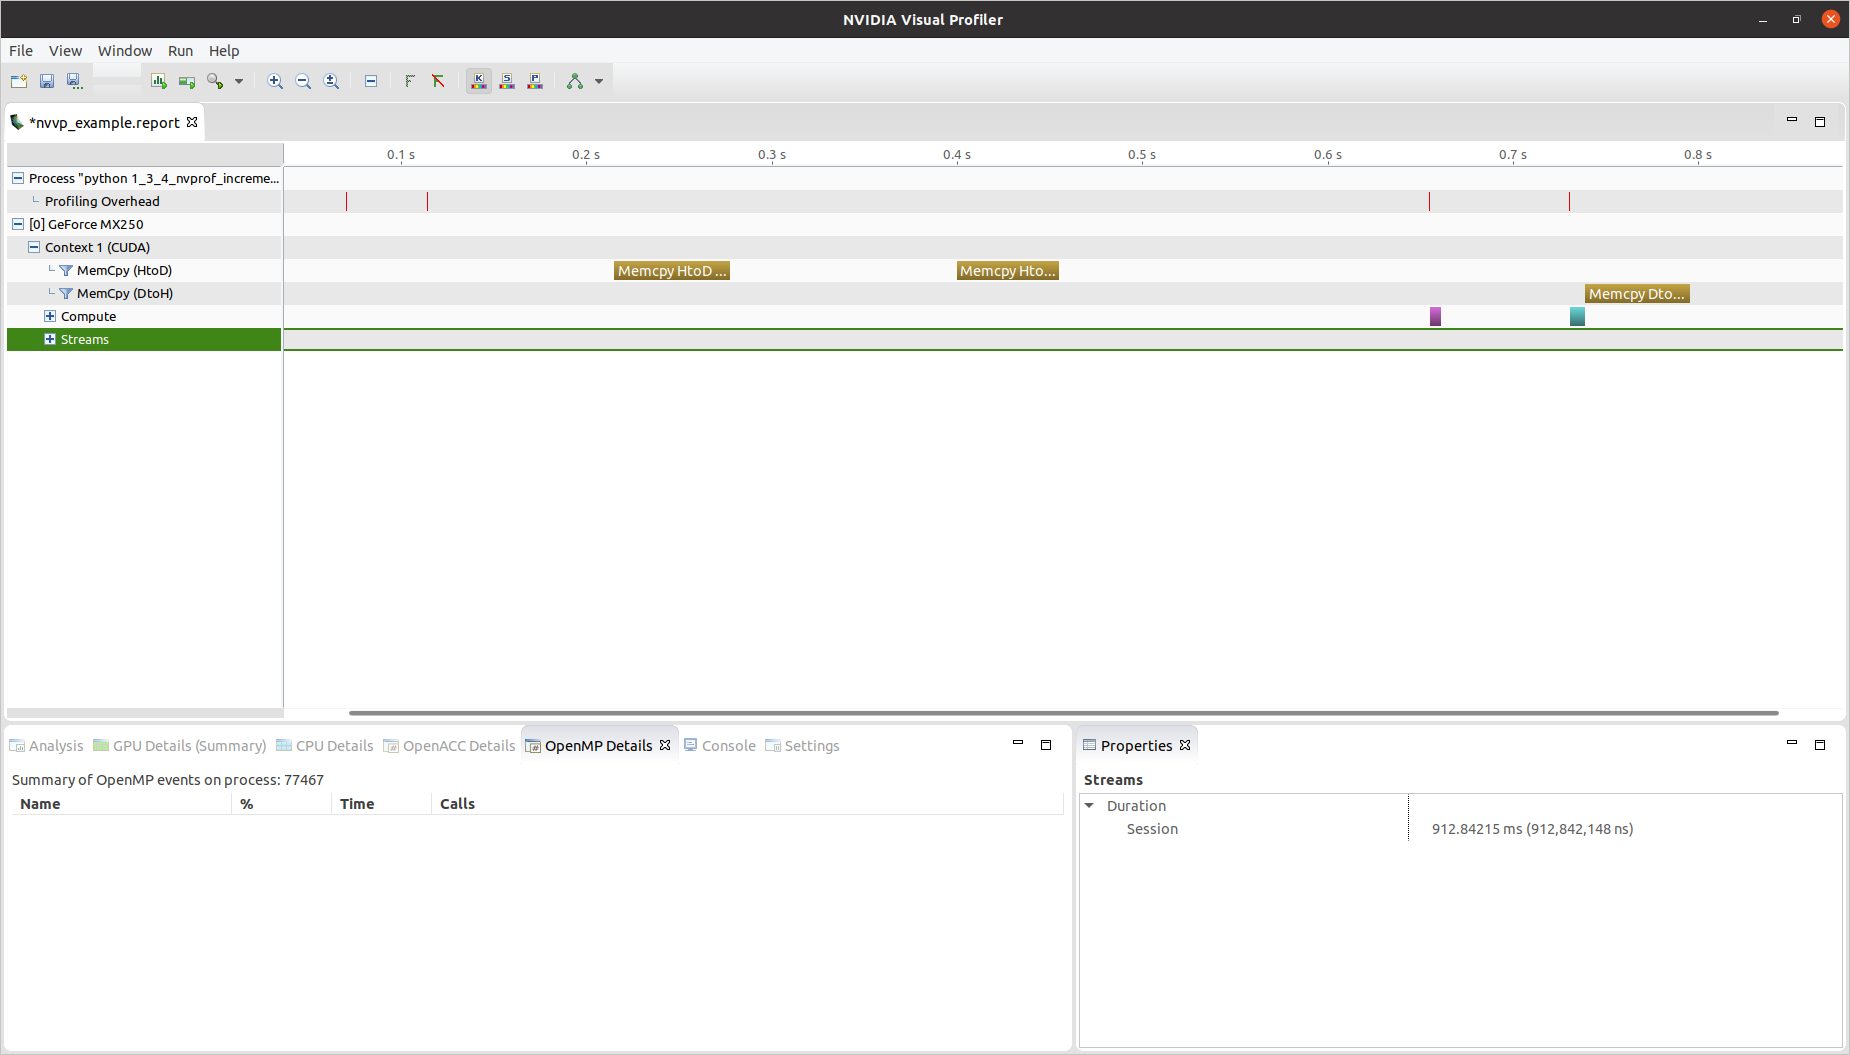

#### 1.3.4.3. NVIDIA Nsight Compute and Systems

In preparation...